In [1]:
import tensorflow as tf
from glob import glob
import h5py

import matplotlib.pyplot as plt
from random import seed, shuffle

/home/ubuntu/miniconda3/envs/audiodream/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/miniconda3/envs/audiodream/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/miniconda3/envs/audiodream/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ubuntu/miniconda3/envs/au

In [2]:
f = h5py.File('./packed_features/unbal_train.h5', 'r')

In [3]:
all_y = f['y']
all_x = f['x']

In [22]:
N = len(all_y)
full_indices =[i for i in range(N)]

In [23]:
RANDOM_SEED = 999

seed(RANDOM_SEED)
shuffle(full_indices)

tf.set_random_seed(RANDOM_SEED)

In [32]:
indices = full_indices[:1000000]

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [33]:
y = all_y[:,0][indices] # zero because it's the speech index

In [89]:
x = all_x.value[indices].astype('float32') # five because it's the middle slice and I only want one frame
def normalize_x_inplace(x):
    x -= 128.0
    x /= 255.0
normalize_x_inplace(x)

In [80]:
features_input = tf.keras.layers.Input(shape=x[0].shape)
l = tf.keras.layers.Flatten()(features_input)
l = tf.keras.layers.Dense(64, activation='relu')(l)
l = tf.keras.layers.Dense(32, activation='relu')(l)
l = tf.keras.layers.Dense(1, activation='sigmoid')(l)

model = tf.keras.Model(features_input, l, name='AudioClassifier')

In [81]:
model.compile('adam', loss='binary_crossentropy')

In [82]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 10, 128)           0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 64)                81984     
_________________________________________________________________
dense_26 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 33        
Total params: 84,097
Trainable params: 84,097
Non-trainable params: 0
_________________________________________________________________


In [87]:
history = model.fit(x, y, batch_size=32, epochs=100, validation_split=0.1, callbacks = [tf.keras.callbacks.EarlyStopping()])

Train on 900000 samples, validate on 100000 samples
Epoch 1/100
900000/900000 [==============================] - 58s 64us/sample - loss: 0.2231 - val_loss: 0.2619
Epoch 2/100
900000/900000 [==============================] - 58s 64us/sample - loss: 0.2182 - val_loss: 0.2639


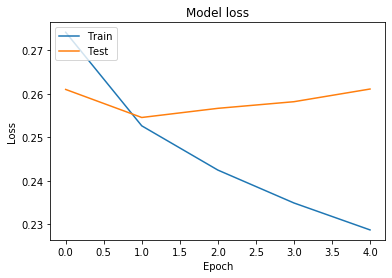

In [84]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [99]:
test_indices = full_indices[1000000:1100000]
test_x = all_x.value[test_indices].astype('float32')
test_y = all_y[:,0][test_indices]
normalize_x_inplace(test_x)

In [109]:
pred_y = model.predict(test_x)
threshold = 0.5
pred_boolean = np.array(pred_y.shape)
pred_boolean = pred_y > threshold

In [117]:
import numpy as np
print(np.mean(pred_y))
print(np.std(pred_y))

pred_correctness = pred_boolean.ravel() == test_y
total = pred_correctness.shape[0]
numerator = np.sum(pred_correctness)
print(f"accuracy: {numerator/total}")

0.49277487
0.42855284
accuracy: 0.89865


[False False  True ... False  True False]
